In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ================================================= Flexible Layer ================================================================================

    
class FlexiLayer(nn.Module): # class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        super(FlexiLayer, self).__init__()
        
        self.t_1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.t_2 = nn.MaxPool2d(self.kernel_size, self.stride, self.padding) # get max result with the same kernel size
        self.m = nn.Sigmoid()
        
        self.threshold1 = Variable(torch.randn((1, self.out_channels, 30, 30)))
        
        self.thresh_mean = []
        
    def forward(self, t):
        
        #self.threshold1.expand(t.size(0), self.out_channels, 30, 30)
        
        
        #cond = torch.sub(self.t_2(t), self.threshold1.cuda())
        #t_2_2 = self.m(cond*50)*self.t_2(t) # 
        #t_1_1 = self.m(cond*(-50))*self.t_1(t) # 
        #t = torch.add(t_2_2, t_1_1)
        
        return self.t_1(t)

    # ================================================= VGG-16 Network ================================================================================
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()

        self.block1 = nn.Sequential(
                      nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      FlexiLayer(in_channels = 64,out_channels = 64,kernel_size = 3, padding =0),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      #nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.3))

        self.block2 = nn.Sequential(
                      nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block3 = nn.Sequential(
                      nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block4 = nn.Sequential(
                      nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2) ,
                      nn.Dropout2d(0.4))

        self.block5 = nn.Sequential(
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.5) )

        self.fc =     nn.Sequential(
                      nn.Linear(512,100),
                      nn.Dropout(0.5),
                      nn.BatchNorm1d(100),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(100,10), )




    def forward(self,x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)

        return out


In [2]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# =================================================== Prepare the dataset ===============================================================================

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

trainset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=True, download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 10 Classes of the cifar-10

# ========================================== Visualising the dataset ==========================================================================
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    print(img.size())
    img = img*std + mean     # unnormalize
    
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])
truck  bird truck  deer


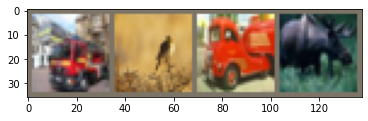

In [3]:
# ======================== Function to get the test accuracy ===============================================================================
def test():
    correct = 0
    total = 0
    model.train(False)
    with torch.no_grad():
        for i,(images,labels)in enumerate(testloader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(Variable(images))
            labels = Variable(labels)
            _,predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted.eq(labels)).sum().item()
        print('Test accuracy: %d %%' % (
        100 * correct / total))
    return 100*(correct/total)

#======================================================= Training =========================================================================

def train(num_epochs, model_number):
    start_epoch = 0
    total_step = len(trainloader)
    train_loss = []  # Store the train_loss per epoch
    test_accuracy = [] # Store the test_accuracy per epoch
    for epoch in range(start_epoch,num_epochs+1):
        model.train(True)
        epoch_loss  = 0
        i_count = 0
        acc_total = 0
        for i,(images,labels) in enumerate(trainloader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            labels = Variable(labels)
            optimizer.zero_grad()
            outputs = model(Variable(images))
            loss = criterion(outputs,labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            _,predicted = outputs.max(1)
            denom = labels.size(0)
            correct = predicted.eq(labels).sum().item()
            acc = 100*(correct/denom)
            acc_total += acc
            i_count = i_count + 1

        schedule.step()
        train_loss.append(epoch_loss)
        print("Epoch: ",epoch," ","Loss: ",epoch_loss," ","Train Accuracy :",acc_total/i_count) # Print train accuracy per epoch
        test_acc = test()      # Print the test accuracy per epoch
        test_accuracy.append(test_acc)
        print('\n')


        if(epoch == num_epochs - 1 ):       # Save the model on the last epoch
            state = {
                'model': model.state_dict(),
                'acc' : test_acc,
                'optim':optimizer.state_dict(),
                'epoch' : epoch
            }
            path = './models/100networks/VGG16-BASE-nnmodule_' + 'model' + model_number + '_' + str(int(epoch)) +'_' + str(int(test_acc))+'.pth'
            torch.save(state,path)
            
            train_error_final_epoch = 100 - acc_total/i_count
            
            return path, train_error_final_epoch

In [4]:
#Need to call the train function 100 times, each with different starting conditions and number of epochs

train_errors = [] #we don't actually care about this
all_models = []

#Get 101 different lengths of epochs, between 10 and 300:
num_models = 5

import random
num_epochs = random.choices([i for i in range(0,300)], k = num_models)  #k should be 101 but would take 12.5 days, if 3hrs each.


for i in range(num_models): #need to reinintialise a model for each iteration, to ensure weights etc are reset.
    
    #============== Model initialisation, Loss function and Optimizer ===========
    model = VGG16()
    if torch.cuda.is_available():
        model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
    schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)
   
    
    path, train_error_i = train(num_epochs[i], i)
    train_errors.append(train_error_i)
    all_models.append(path)
    
    #Train with Newton optimiser to find nearest critical point (do in a seperate script)


Epoch:  0   Loss:  1074.3043876886368   Train Accuracy : 17.628
Test accuracy: 16 %


Epoch:  1   Loss:  948.488648891449   Train Accuracy : 26.258
Test accuracy: 25 %


Epoch:  2   Loss:  882.9758962392807   Train Accuracy : 32.914
Test accuracy: 32 %


Epoch:  3   Loss:  837.7467423677444   Train Accuracy : 36.824
Test accuracy: 40 %


Epoch:  4   Loss:  802.8506246805191   Train Accuracy : 40.284
Test accuracy: 44 %


Epoch:  5   Loss:  763.7773313522339   Train Accuracy : 44.036
Test accuracy: 47 %


Epoch:  6   Loss:  728.0223460197449   Train Accuracy : 47.598
Test accuracy: 54 %


Epoch:  7   Loss:  692.117476940155   Train Accuracy : 51.632
Test accuracy: 57 %


Epoch:  8   Loss:  652.3734384775162   Train Accuracy : 55.2
Test accuracy: 61 %


Epoch:  9   Loss:  620.6758863329887   Train Accuracy : 58.164
Test accuracy: 62 %


Epoch:  10   Loss:  589.9884436130524   Train Accuracy : 60.612
Test accuracy: 66 %


Epoch:  11   Loss:  563.6973606944084   Train Accuracy : 62.78
Test

TypeError: can only concatenate str (not "int") to str

In [5]:
#For alpha - epsilon plot we want test accuracy at the final epoch after Newton method.
import pickle

with open('cifar_base_100model_paths.pkl', 'wb') as f:
    pickle.dump(all_models, f)